In [1]:
#from data_utils import *
import tensorflow as tf
from tensorflow.contrib import rnn, cudnn_rnn
from tensorflow.keras import layers
from keras.layers.convolutional_recurrent import ConvLSTM2D,ConvLSTM2DCell
from keras.layers.convolutional import Conv3D
import time
import os
import sys
import numpy as np

import random
import os
from PIL import Image
import keras.regularizers
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, LSTM, Activation, Lambda, Reshape
from keras.layers import Concatenate
from keras.models import Model, Sequential
from keras import backend as K

from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Load data functions

def get_train_batch(batch_size, n_seq=10000, T=10, K=10, dir='Data/train_sequence/'):
    selected_idx = random.sample(range(n_seq), batch_size)
    input = np.zeros([batch_size, T, 64, 64, 3])
    
    output = np.zeros([batch_size, K, 64, 64, 3])
    for i, idx in enumerate(selected_idx):
        for t in range(T+K):
            img_path = os.path.join(dir, 'sequence%04d' % idx, 'frames%02d.png' % t)
            img = np.array(Image.open(img_path)) / 255.0  # normalize
            if t < 10:
                input[i, t] = img
            else:
                output[i, t-10] = img
    
    
    return input, output


def get_val_batch(start, end, T=10, K=10, dir='Data/val_sequence/'):
    input = np.zeros([end-start, T, 64, 64, 3])
    output = np.zeros([end-start, K, 64, 64, 3])
    for i, idx in enumerate(range(start, end)):
        for t in range(T+K):
            img_path = os.path.join(dir, 'sequence%03d' % idx, 'frames%02d.png' % t)
            img = np.array(Image.open(img_path)) / 255.0  # normalize
            if t < 10:
                input[i, t] = img
            else:
                output[i, t-10] = img

    return input, output


def get_test_batch(start, end, T=10, dir='Data/test_sequence/'):
    input = np.zeros([end-start, T, 64, 64, 3])
    for i, idx in enumerate(range(start, end)):
        for t in range(T):
            img_path = os.path.join(dir, 'sequence%03d' % idx, 'frames%02d.png' % t)
            img = np.array(Image.open(img_path)) / 255.0  # normalize
            input[i, t] = img

    return input


In [3]:
## Hyperparameters
training_size=512
batch_size=128
learning_rate=0.001
num_layers=2 # layer num of LSTM
num_hidden=64 # state num of LSTM??
timesteps=10
epochs=100

In [4]:
## Load data
train_input, train_output= get_train_batch(training_size)
val_input, val_output= get_val_batch(start=0,end=500)
test_input = get_test_batch(start=0,end=500)


In [5]:

train_reshape_version=np.reshape(train_input[:,-1],(training_size,1,64,64,3))

train_output_shift=np.concatenate((train_reshape_version,train_output[:,:9]),axis=1)

val_reshape_version=np.reshape(val_input[:,-1],(500,1,64,64,3))

val_output_shift=np.concatenate((val_reshape_version,val_output[:,:9]),axis=1)



In [6]:
print(val_input.shape)
print(val_output.shape)


(500, 10, 64, 64, 3)
(500, 10, 64, 64, 3)


In [7]:
## make autoencoder

input_img = Input(shape=(64, 64, 3)) 

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# meaningful feature: (8,8,16) dimension

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
## encoder model
encoder = Model(input_img, encoded)

In [9]:
## decoder model
encoded_input = Input(shape=(8,8,16))

decoder_layer = autoencoder.layers[7:]
get_decoded=decoder_layer[0](encoded_input)
for i in range(1,7):
    get_decoded=decoder_layer[i](get_decoded)
decoder = Model(encoded_input, get_decoded)

In [10]:
## training autoencoder
train_input_reshape=np.reshape(train_input,(training_size*10,64,64,3))
val_input_reshape=np.reshape(val_input,(500*10,64,64,3))
autoencoder.fit(train_input_reshape, train_input_reshape,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(val_input_reshape, val_input_reshape),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Instructions for updating:
Use tf.cast instead.
Train on 5120 samples, validate on 5000 samples
Epoch 1/50
5120/5120 [==============================] - 18s 3ms/step - loss: 0.2182 - val_loss: 0.0725
Epoch 2/50
5120/5120 [==============================] - 7s 1ms/step - loss: 0.0594 - val_loss: 0.0550
Epoch 3/50
5120/5120 [==============================] - 7s 1ms/step - loss: 0.0537 - val_loss: 0.0517
Epoch 4/50
5120/5120 [==============================] - 7s 1ms/step - loss: 0.0507 - val_loss: 0.0492
Epoch 5/50
5120/5120 [==============================] - 7s 1ms/step - loss: 0.0467 - val_loss: 0.0432
Epoch 6/50
5120/5120 [==============================] - 7s 1ms/step - loss: 0.0405 - val_loss: 0.0379
Epoch 7/50
5120/5120 [==============================] - 7s 1ms/step - loss: 0.0372 - val_loss: 0.0365
Epoch 8/50
5120/5120 [==============================] - 7s 1ms/step - loss: 0.0357 - val_loss: 0.0350
Epoch 9/50
5120/5120 [==============================] - 7s 1ms/step - loss: 0.0348 - va

KeyboardInterrupt: 

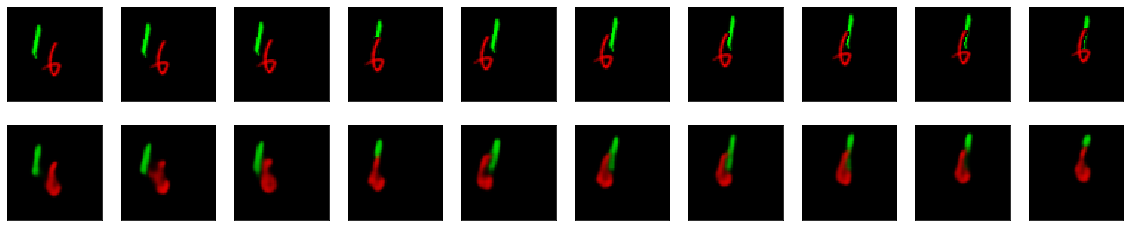

In [11]:
## show images


decoded_imgs_toshow = autoencoder.predict(val_input_reshape)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_input_reshape[i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +1 + n)
    plt.imshow(decoded_imgs_toshow[i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
def put_to_encoder(x):
    return encoder(x)

def put_to_decoder(x):
    return decoder(x)

def reshape_with_batch(x):
    return tf.reshape(x,shape=(-1,64,64,3))

def reshape_with_batch2(x):
    return tf.reshape(x,shape=(-1,8,8,16))

def reshape_apart_with_batch(x):
    return tf.reshape(x,shape=(-1,timesteps,8,8,16))

def reshape_apart_with_batch2(x):
    return tf.reshape(x,shape=(-1,timesteps,64,64,3))

def normalize(x):
    return x*255

def solve_nan(x):
    return np.nan_to_num(x)

def zero_tf(x):
    return tf.zeros(shape=(None,timesteps,64,64,3))

def encoder_stack(x):
    x=tf.reshape(x,shape=(-1,1,8,8,16))
    encoder_list=[]
    for i in range(10):
        encoder_list=encoder_list+[x]
    return encoder_list

def reshape_encoder(x):
    return tf.reshape(x,shape=(-1,1,8,8,16))

In [13]:
## Convolution LSTM cell encoder level
'''
cells = [ConvLSTM2DCell(filters=16,kernel_size=(3,3),
                     activation='sigmoid',padding='same',
                     ) for i in range(num_layers)]

lstm_cell = ConvLSTM2DCell(filters=16,kernel_size=(3,3),
                     activation='sigmoid',padding='same')
'''
# model=Sequential()

# get input image sequence
input_img_sequence = Input(shape=(timesteps,64, 64, 3)) 

# put input to encoder, use later when fit

input_img_sequence_reshape = Lambda(reshape_with_batch)(input_img_sequence)

input_img_sequence_reshape = Lambda(put_to_encoder)(input_img_sequence_reshape)

input_img_sequence_reshape = Lambda(reshape_apart_with_batch)(input_img_sequence_reshape)

# put 1 layer convLSTM2D 
encoder_model,state_h,state_c = ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu',
                            input_shape=(timesteps, 8, 8, 16), return_sequences=False,
                           return_state=True,
#                            kernel_regularizer=keras.regularizers.l2(0.01),
#                            bias_regularizer=keras.regularizers.l2(0.01),
#                             activity_regularizer=keras.regularizers.l1(0.01),
                            padding='same')(input_img_sequence_reshape)


# use only states
encoder_states=[state_h[:], state_c[:]]



In [14]:
## Convolution LSTM cell decoder level

# 1 layer of convLSTM..?

#
# decoder_input = Input(shape=(timesteps,64,64,3))

# put input to encoder, use later when fit
'''
decoder_input=Lambda(zero_tf)(encoder_model)

decoder_img_sequence_reshape = Lambda(reshape_with_batch)(decoder_input)

decoder_img_sequence_reshape = Lambda(put_to_encoder)(decoder_img_sequence_reshape)

decoder_img_sequence_reshape = Lambda(reshape_apart_with_batch)(decoder_img_sequence_reshape)
'''

encoder_list= Lambda(encoder_stack)(encoder_model)

encoder_model = Concatenate(axis=1)(encoder_list)
print(encoder_model)
decoder_model = ConvLSTM2D(filters=16, kernel_size=(3,3), activation='sigmoid',
                            input_shape=(timesteps, 8, 8, 16), 
                            return_sequences=True,
#                       kernel_regularizer=keras.regularizers.l2(0.01),
#                            bias_regularizer=keras.regularizers.l2(0.01),
#                             activity_regularizer=keras.regularizers.l1(0.01),
                            padding='same')(encoder_model,initial_state=encoder_states)


decoder_output = Lambda(reshape_with_batch2)(decoder_model)

decoder_output = Lambda(put_to_decoder)(decoder_output)

decoder_output = Lambda(reshape_apart_with_batch2)(decoder_output)

decoder_output = Activation('relu')(decoder_output)

# decoder_output = Lambda(solve_nan)(decoder_output)

model=Model(input_img_sequence,decoder_output)

Tensor("concatenate_1/concat:0", shape=(?, 10, 8, 8, 16), dtype=float32)


In [ ]:
## train model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
model.fit(train_input, train_output,

                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(val_input, val_output))
#          callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 64, 64, 3 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 8, 8, 16)     0           lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 10, 8, 8, 16) 0           lambda_2[0][0]                   
__________________________________________________________________________________________________
conv_lst_m

In [ ]:

model_decoded_imgs_toshow = model.predict(val_input)

number = 10
plt.figure(figsize=(20, 4))

for i in range(number):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_output[0,i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +1 + n)
    plt.imshow(model_decoded_imgs_toshow[0,i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
model_predicted_imgs_toshow = model.predict(test_input)

for i in range(500):
    for j in range(10):
       
        
        test_img_path = os.path.join('test_predicted/','sequence%03d' % i, 'frames%02d.png' % j) 
        save_img(test_img_path,model_predicted_imgs_toshow[i][j])
#         tf.io.write_file(test_img_path,model_predicted_imgs_toshow[i][j])


In [ ]:
model.save_weights("model.h5")